# Modelling

In [1]:
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import re
from pingouin import corr
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

### Loading the data file

In [2]:
df = pd.read_excel('data.xlsx')
df

,OrderNr,OrderDate,ItemCode,ItemDescr,SizeSalesPriceAmt,OrderLineSizeCountrySugRetailPriceAmt,SalesPriceAmtAdm,SugRetailPriceAmtAdm,SizeOrderedQty,AccRecCode,...,sub_productgroep,categories,category_paths,material,materiaal_voering,materiaal_zool,naam_schoen,soort_sluiting,customer_order_id,status_order
0,2135797,2021-09-09,222481-720,AF Noa Nopje/Navy,34.95,59.95,24.98,59.95,-1,ZALANDO DE,...,Lage Sneakers,Jongenssneakers,Jongensschoenen > Jongenssneakers,leatherlook,Leatherlook,EVA,Noa Nopje,Veters met rits,48576,return
1,2135874,2021-09-09,222481-720,AF Noa Nopje/Navy,34.95,59.95,24.98,59.95,-1,ZALANDO DE,...,Lage Sneakers,Jongenssneakers,Jongensschoenen > Jongenssneakers,leatherlook,Leatherlook,EVA,Noa Nopje,Veters met rits,48356,return
2,2135875,2021-09-09,222481-720,AF Noa Nopje/Navy,34.95,59.95,24.98,59.95,-1,ZALANDO DE,...,Lage Sneakers,Jongenssneakers,Jongensschoenen > Jongenssneakers,leatherlook,Leatherlook,EVA,Noa Nopje,Veters met rits,48458,return
3,2136730,2021-09-14,222493-771,AF Liv Londen/ Lila,34.95,69.95,29.15,69.95,-1,ZALANDO,...,Lage Sneakers,Meisjessneakers,Meisjesschoenen > Meisjessneakers,leatherlook,Leatherlook,EVA,Liv Londen,Veters met rits,49194,return
4,2136826,2021-09-14,222481-781,AF Noa Nopje/Light Grey,34.95,59.95,24.98,59.95,-1,ZALANDO DE,...,Lage Sneakers,Animal Friendly kinderschoenen,Animal Friendly kinderschoenen,leatherlook,Leatherlook,EVA,Noa Nopje,Veters met rits,49314,return
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,2247760,2023-03-09,222848-413,Gabriel Gein-Cognac,69.95,89.95,0.00,0.00,1,B2C-NL,...,Hoge Sneakers,SALE | Meisjes,Bunnies JR | kinderschoenen sale > SALE | Meisjes,leer/suede/mesh,Leatherlook,Rubber,Gabriel Gein,Veters met rits,3000078871,sale
51140,2247761,2023-03-09,222552-478,Reese Rap/Nude,49.95,59.95,27.25,59.95,-1,ZFS DE,...,Hoge Sneakers,SALE | Meisjes,Bunnies JR | kinderschoenen sale > SALE | Meisjes,suede,Leatherlook,Rubber,Reese Rap,Veters,7287,return
51141,2247763,2023-03-09,422771-998,Belle Boot/Multicolor,49.95,99.95,41.65,99.95,1,ZFS FR,...,Biker Boots,Biker boots voor meiden,Meisjesschoenen > Meisjeslaarzen > Biker boots...,leer,Leatherlook,Rubber,Belle Boot,Veters met rits,7516,sale
51142,2247766,2023-03-09,422792-471,Robin Run/Lila,59.95,99.95,41.65,99.95,1,OMODA,...,Lage Sneakers,Meisjessneakers,Meisjesschoenen > Meisjessneakers,suede/mesh,Leatherlook,EVA,Robin Run,Veters,26765709,sale


### Removing the status_order column

In [3]:
df = df.drop('status_order', axis=1)

# Prepare the data 

### Grouping the data

In [4]:
# calculate the total sales and returns for each group
df['SalesQty'] = df['SizeOrderedQty'].apply(lambda x: max(x, 0)) # convert negative values to 0 for sales
df['ReturnQty'] = df['SizeOrderedQty'].apply(lambda x: -min(x, 0)) # convert positive values to 0 for returns
total_sales = df.groupby(['ItemDescr', 'size', 'material', 'productgroup', 'seizoen', 'BrandCode'])['SalesQty'].sum()
total_returns = df.groupby(['ItemDescr', 'size', 'material', 'productgroup', 'seizoen', 'BrandCode'])['ReturnQty'].sum()

In [5]:
# calculate the return percentage for each group, skipping groups with zero total sales and returns
return_percent = (total_returns / (total_sales + total_returns)) * 100
# rename the return percentage column to "return_percentage"
return_percent.rename('return_percentage', inplace=True)

ItemDescr                  size  material     productgroup    seizoen        BrandCode
AF Liv Londen/ Light Grey  28    leatherlook  Kindersneakers  Lente/Zomer    BJR          38.461538
                           29    leatherlook  Kindersneakers  Lente/Zomer    BJR          36.363636
                           30    leatherlook  Kindersneakers  Lente/Zomer    BJR          36.363636
                           31    leatherlook  Kindersneakers  Lente/Zomer    BJR          33.333333
                           32    leatherlook  Kindersneakers  Lente/Zomer    BJR          14.285714
                                                                                            ...    
Zusje Zacht/Old Pink       18    leer         Babyschoentjes  Herfst/Winter  BJR          37.500000
                           19    leer         Babyschoentjes  Herfst/Winter  BJR          28.571429
                           20    leer         Babyschoentjes  Herfst/Winter  BJR          50.000000
             

In [6]:
df_grouped = pd.DataFrame(return_percent).reset_index()
df_grouped['return_percentage'] = df_grouped['return_percentage'].round(2)
df_grouped

,ItemDescr,size,material,productgroup,seizoen,BrandCode,return_percentage
0,AF Liv Londen/ Light Grey,28,leatherlook,Kindersneakers,Lente/Zomer,BJR,38.46
1,AF Liv Londen/ Light Grey,29,leatherlook,Kindersneakers,Lente/Zomer,BJR,36.36
2,AF Liv Londen/ Light Grey,30,leatherlook,Kindersneakers,Lente/Zomer,BJR,36.36
3,AF Liv Londen/ Light Grey,31,leatherlook,Kindersneakers,Lente/Zomer,BJR,33.33
4,AF Liv Londen/ Light Grey,32,leatherlook,Kindersneakers,Lente/Zomer,BJR,14.29
...,...,...,...,...,...,...,...
2365,Zusje Zacht/Old Pink,18,leer,Babyschoentjes,Herfst/Winter,BJR,37.50
2366,Zusje Zacht/Old Pink,19,leer,Babyschoentjes,Herfst/Winter,BJR,28.57
2367,Zusje Zacht/Old Pink,20,leer,Babyschoentjes,Herfst/Winter,BJR,50.00
2368,Zusje Zacht/Old Pink,21,leer,Babyschoentjes,Herfst/Winter,BJR,33.33


In [7]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ItemDescr          2370 non-null   object 
 1   size               2370 non-null   int64  
 2   material           2370 non-null   object 
 3   productgroup       2370 non-null   object 
 4   seizoen            2370 non-null   object 
 5   BrandCode          2370 non-null   object 
 6   return_percentage  2370 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 129.7+ KB


### Hot one encoding

In [8]:
# Columns to perform one-hot encoding on
selected_columns = ['material','productgroup', 'seizoen', 'BrandCode']
# Perform one-hot encoding on selected columns
one_hot_encoded_df = pd.get_dummies(df_grouped, columns=selected_columns, dtype = int)
one_hot_encoded_df.head()

,ItemDescr,size,return_percentage,material_leatherlook,material_leer,material_leer/mesh,material_leer/nubuck/mesh,material_leer/suede,material_leer/suede/mesh,material_nubuck,...,productgroup_Kinderlaarsjes,productgroup_Kindersandalen,productgroup_Kindersneakers,productgroup_Laarzen & boots,productgroup_Sandalen,productgroup_Sneakers,seizoen_Herfst/Winter,seizoen_Lente/Zomer,BrandCode_BJR,BrandCode_BQZ
0,AF Liv Londen/ Light Grey,28,38.46,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,AF Liv Londen/ Light Grey,29,36.36,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,AF Liv Londen/ Light Grey,30,36.36,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,AF Liv Londen/ Light Grey,31,33.33,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,AF Liv Londen/ Light Grey,32,14.29,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


# Images

### Preparing the images

In [9]:
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import pandas as pd

# Assume df is your DataFrame and it has been defined already

# Define some parameters
img_width, img_height = 150, 150
base_dirs = ['C:/Users/maxwe/Documents/Github repos/Shoes-Modelling-Max/bunnies-jr-ss21-en-ss22_2023-03-31_1035', 
             'C:/Users/maxwe/Documents/Github repos/Shoes-Modelling-Max/wetransfer_bunnies-jr-aw21-en-aw22_2023-03-31_1036']  # Now it's a list of directories

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
            x = img_to_array(img)  # this is a Numpy array with shape (img_width, img_height, 3)
            images.append(x)
    return images

# Get the itemcodes (shoes) from the DataFrame
itemcodes = df['ItemCode'].tolist()

# Initialize the images dictionary
images_dict = {}

# Load the processed itemcodes
try:
    with open('processed_itemcodes.pkl', 'rb') as f:
        processed_itemcodes = pickle.load(f)
except FileNotFoundError:
    processed_itemcodes = set()

for base_dir in base_dirs:
    for itemcode in itemcodes:
        # Skip if the itemcode has been processed already
        if itemcode in processed_itemcodes:
            continue

        item_path = os.path.join(base_dir, itemcode)
        # Check if the itemcode folder exists in the directory
        if os.path.isdir(item_path):
            images = load_images_from_folder(item_path)

            # Assuming the itemcode is unique across brands,
            # use the itemcode as the key and the list of images as the value
            images_dict[itemcode] = images

            # Add this itemcode to the processed itemcodes set
            processed_itemcodes.add(itemcode)

# Convert to numpy array for the model
for itemcode, images in images_dict.items():
    images_dict[itemcode] = np.array(images)

# Save the processed itemcodes
with open('processed_itemcodes.pkl', 'wb') as f:
    pickle.dump(processed_itemcodes, f)


In [10]:
import matplotlib.pyplot as plt

# Display one image per itemcode
for itemcode, images in images_dict.items():
    if images.size > 0:  # Ensure there are images for this itemcode
        plt.imshow(images[0] / 255.)  # Dividing by 255 to rescale pixel values to [0, 1]
        plt.title(f'ItemCode: {itemcode}')
        plt.show()

In [11]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd

# Define some parameters
img_width, img_height = 150, 150
base_dir = 'C:/Users/maxwe/Documents/Github repos/Shoes-Modelling-Max/bunnies-jr-ss21-en-ss22_2023-03-31_1035'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
            x = img_to_array(img)  # this is a Numpy array with shape (img_width, img_height, 3)
            images.append(x)
    return images

# Get the itemcodes (shoes) from the DataFrame
itemcodes_df = df['ItemCode'].tolist()

# Initialize the images dictionary
images_dict = {}

# Initialize counters
total_images = 0
images_with_itemcode = 0

# Get all the itemcodes from the directory
itemcodes_dir = os.listdir(base_dir)

for itemcode in itemcodes_dir:
    item_path = os.path.join(base_dir, itemcode)
    # Check if the itemcode folder exists in the directory
    if os.path.isdir(item_path):
        images = load_images_from_folder(item_path)
        total_images += len(images)

        # If this itemcode is in the dataframe, increment the counter
        if itemcode in itemcodes_df:
            images_with_itemcode += len(images)
            images_dict[itemcode] = np.array(images)

# Print the results
print(f'Total images: {total_images}')
print(f'Images with itemcode: {images_with_itemcode}')
print(f'Images without itemcode: {total_images - images_with_itemcode}')

Total images: 1181
Images with itemcode: 649
Images without itemcode: 532


## Preparing labels

In [12]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd

# Define some parameters
img_width, img_height = 150, 150
base_dir = 'bunnies-jr-ss21-en-ss22_2023-03-31_1035'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
            x = img_to_array(img)  # this is a Numpy array with shape (img_width, img_height, 3)
            images.append(x)
    return images

# Get the itemcodes (shoes) and corresponding sub_productgroep from the DataFrame
df = df.dropna(subset=['ItemCode', 'sub_productgroep'])  # drop rows with NaN in these columns
itemcode_subproduct_dict = dict(zip(df['ItemCode'], df['sub_productgroep']))

# Initialize the images and labels lists
images_list = []
labels_list = []

for itemcode, sub_productgroep in itemcode_subproduct_dict.items():
    item_path = os.path.join(base_dir, itemcode)
    # Check if the itemcode folder exists in the directory
    if os.path.isdir(item_path):
        images = load_images_from_folder(item_path)
        
        # Add each image to the images list and the corresponding sub_productgroep to the labels list
        for image in images:
            images_list.append(image)
            labels_list.append(sub_productgroep)

# Convert to numpy arrays for the model
images_np = np.array(images_list)
labels_np = np.array(labels_list)

## Predicting the Sub_productgroep

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Transform labels to integer for the model
le = LabelEncoder()
labels_np_int = le.fit_transform(labels_np)

# Convert labels to categorical
labels_np_cat = to_categorical(labels_np_int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np_cat, test_size=0.2, random_state=42)

# Normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
17/17 [==============================] - 4s 220ms/step - loss: 2.9613 - accuracy: 0.4547 - val_loss: 1.0246 - val_accuracy: 0.6923
Epoch 2/10
17/17 [==============================] - 3s 196ms/step - loss: 0.9478 - accuracy: 0.6782 - val_loss: 0.6581 - val_accuracy: 0.7846
Epoch 3/10
17/17 [==============================] - 3s 194ms/step - loss: 0.7294 - accuracy: 0.7553 - val_loss: 0.6169 - val_accuracy: 0.8077
Epoch 4/10
17/17 [==============================] - 3s 201ms/step - loss: 0.6030 - accuracy: 0.7938 - val_loss: 0.4435 - val_accuracy: 0.8538
Epoch 5/10
17/17 [==============================] - 3s 188ms/step - loss: 0.4439 - accuracy: 0.8478 - val_loss: 0.3253 - val_accuracy: 0.8923
Epoch 6/10
17/17 [==============================] - 3s 191ms/step - loss: 0.3792 - accuracy: 0.8632 - val_loss: 0.3421 - val_accuracy: 0.9231
Epoch 7/10
17/17 [==============================] - 3s 192ms/step - loss: 0.3036 - accuracy: 0.9114 - val_loss: 0.3082 - val_accuracy: 0.9077
Epoch 

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


5/5 [==============================] - 0s 32ms/step - loss: 0.3092 - accuracy: 0.9308
Test loss: 0.30916544795036316
Test accuracy: 0.9307692050933838


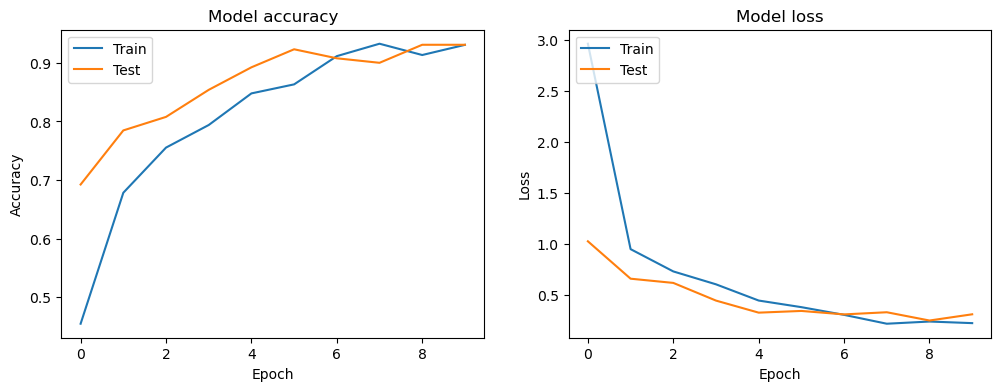

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


5/5 [==============================] - 0s 30ms/step


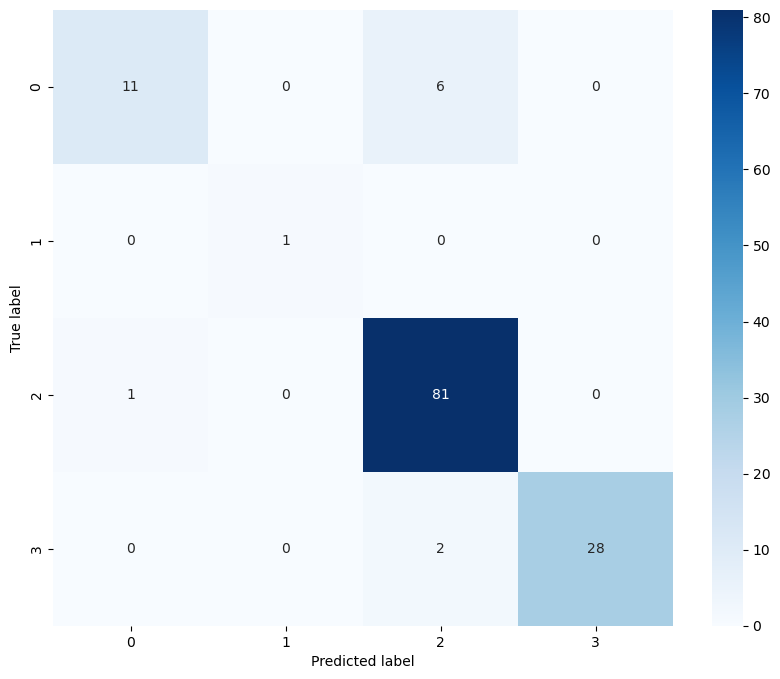

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


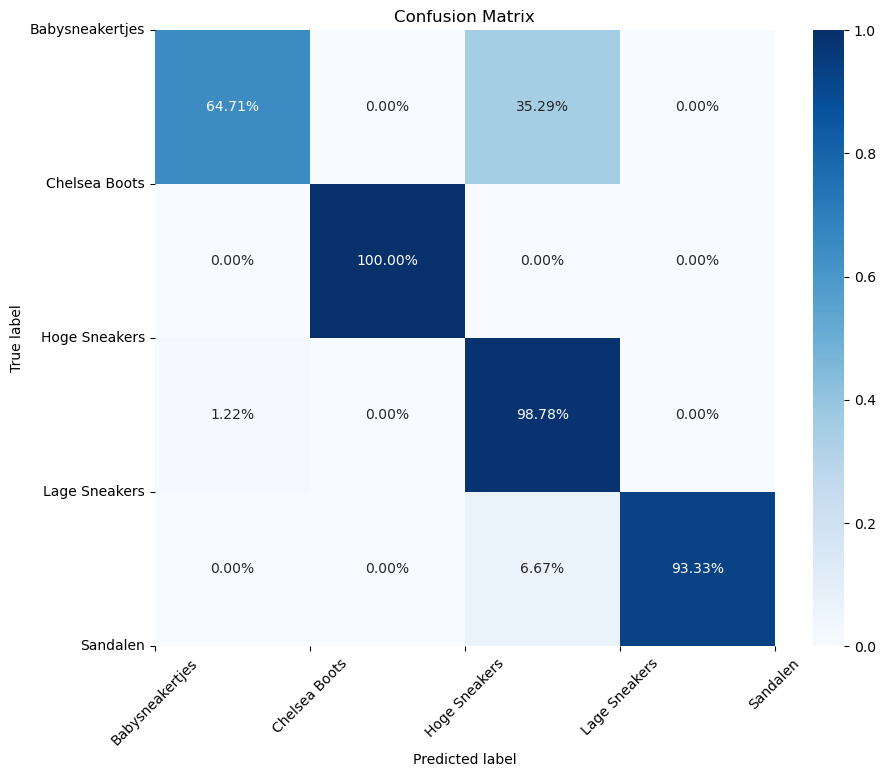

In [17]:
# Normalize the confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45)
plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=0)
plt.title('Confusion Matrix')
plt.show()

In a confusion matrix:

- Each row corresponds to the true class of the instances.
- Each column corresponds to the predicted class according to your model.
- The cell at the intersection of a row and a column shows the number of instances of the class corresponding to that row which were predicted as belonging to the class corresponding to that column.

In [18]:
# List all columns in the DataFrame
print(df.columns.tolist())


['OrderNr', 'OrderDate', 'ItemCode', 'ItemDescr', 'SizeSalesPriceAmt', 'OrderLineSizeCountrySugRetailPriceAmt', 'SalesPriceAmtAdm', 'SugRetailPriceAmtAdm', 'SizeOrderedQty', 'AccRecCode', 'AccRecName', 'SizeCode', 'DelAddressCity', 'SegmentDescr', 'BrandCode', 'CustomerOrder', 'sku', 'gender', 'parent_sku', 'ean', 'size', 'stock', 'title', 'kleur_magento', 'price', 'sale_price', 'seizoen', 'seizoensjaar', 'productgroup', 'sub_productgroep', 'categories', 'category_paths', 'material', 'materiaal_voering', 'materiaal_zool', 'naam_schoen', 'soort_sluiting', 'customer_order_id', 'SalesQty', 'ReturnQty']


## Predicting the ProductGroup

Epoch 1/10
17/17 [==============================] - 4s 197ms/step - loss: 1.4959 - accuracy: 0.5414 - val_loss: 0.9088 - val_accuracy: 0.6077
Epoch 2/10
17/17 [==============================] - 3s 191ms/step - loss: 0.7656 - accuracy: 0.7013 - val_loss: 0.7453 - val_accuracy: 0.6923
Epoch 3/10
17/17 [==============================] - 3s 194ms/step - loss: 0.5952 - accuracy: 0.8073 - val_loss: 0.5002 - val_accuracy: 0.8538
Epoch 4/10
17/17 [==============================] - 3s 200ms/step - loss: 0.4240 - accuracy: 0.8497 - val_loss: 0.3366 - val_accuracy: 0.8846
Epoch 5/10
17/17 [==============================] - 3s 196ms/step - loss: 0.3244 - accuracy: 0.8690 - val_loss: 0.4587 - val_accuracy: 0.8769
Epoch 6/10
17/17 [==============================] - 3s 197ms/step - loss: 0.2658 - accuracy: 0.9037 - val_loss: 0.2783 - val_accuracy: 0.9308
Epoch 7/10
17/17 [==============================] - 3s 195ms/step - loss: 0.1928 - accuracy: 0.9268 - val_loss: 0.2418 - val_accuracy: 0.9308
Epoch 

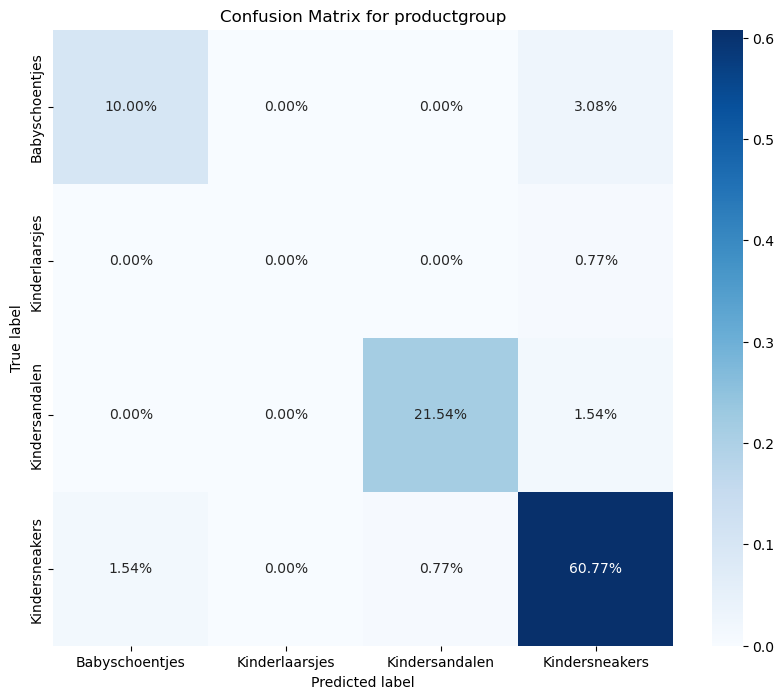

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the itemcodes (shoes) and corresponding label from the DataFrame
df = df.dropna(subset=['ItemCode', 'productgroup'])  # drop rows with NaN in these columns
itemcode_label_dict = dict(zip(df['ItemCode'], df['productgroup']))

# Initialize the images and labels lists
images_list = []
labels_list = []

for itemcode, current_label in itemcode_label_dict.items():
    item_path = os.path.join(base_dir, itemcode)
    # Check if the itemcode folder exists in the directory
    if os.path.isdir(item_path):
        images = load_images_from_folder(item_path)

        # Add each image to the images list and the corresponding label to the labels list
        for image in images:
            images_list.append(image)
            labels_list.append(current_label)

# Convert to numpy arrays for the model
images_np = np.array(images_list)
labels_np = np.array(labels_list)

# Transform labels to integer for the model
le = LabelEncoder()
labels_np_int = le.fit_transform(labels_np)

# Convert labels to categorical
labels_np_cat = to_categorical(labels_np_int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np_cat, test_size=0.2, random_state=42)

# Normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the model
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Show the accuracy
accuracy = np.sum(y_pred_classes == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy for productgroup: {accuracy}')

# Show the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Define class names for labels
class_names = le.classes_

# Plot the confusion matrix with percentage
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx / np.sum(confusion_mtx), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for productgroup')
plt.show()


Epoch 1/10
17/17 [==============================] - 3s 199ms/step - loss: 0.1345 - accuracy: 0.9518 - val_loss: 0.3173 - val_accuracy: 0.9077
Epoch 2/10
17/17 [==============================] - 3s 193ms/step - loss: 0.1123 - accuracy: 0.9615 - val_loss: 0.2737 - val_accuracy: 0.9308
Epoch 3/10
17/17 [==============================] - 3s 192ms/step - loss: 0.1109 - accuracy: 0.9711 - val_loss: 0.3418 - val_accuracy: 0.9000
Epoch 4/10
17/17 [==============================] - 3s 189ms/step - loss: 0.0949 - accuracy: 0.9769 - val_loss: 0.2298 - val_accuracy: 0.9308
Epoch 5/10
17/17 [==============================] - 3s 192ms/step - loss: 0.0667 - accuracy: 0.9750 - val_loss: 0.2285 - val_accuracy: 0.9308
Epoch 6/10
17/17 [==============================] - 3s 187ms/step - loss: 0.0637 - accuracy: 0.9807 - val_loss: 0.2634 - val_accuracy: 0.9308
Epoch 7/10
17/17 [==============================] - 3s 184ms/step - loss: 0.0780 - accuracy: 0.9769 - val_loss: 0.3542 - val_accuracy: 0.9231
Epoch 

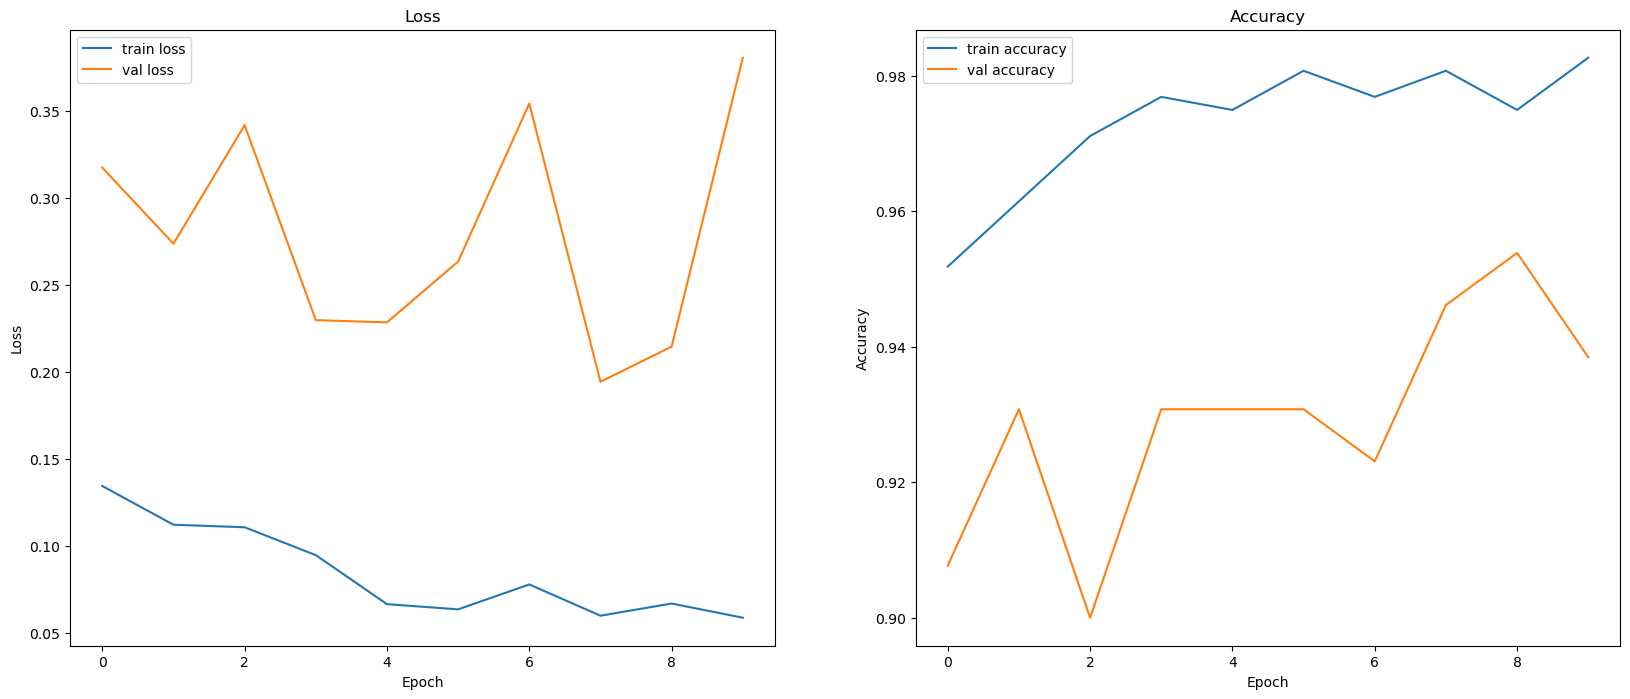

5/5 [==============================] - 0s 29ms/step
                precision    recall  f1-score   support

Babyschoentjes       0.88      0.82      0.85        17
Kinderlaarsjes       1.00      1.00      1.00         1
Kindersandalen       0.91      1.00      0.95        30
Kindersneakers       0.96      0.94      0.95        82

      accuracy                           0.94       130
     macro avg       0.94      0.94      0.94       130
  weighted avg       0.94      0.94      0.94       130



In [20]:

# Train the model
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot both loss and accuracy in one figure
plt.figure(figsize=(20,8))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Get the predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Show classification report for precision, recall f1-score and accuracy
class_names = le.classes_
classification_metrics = classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=class_names)
print(classification_metrics)

In [21]:

# Train the model
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot both loss and accuracy in one figure
plt.figure(figsize=(20,8))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Get the predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Show classification report for precision, recall f1-score and accuracy
class_names = le.classes_
classification_metrics = classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=class_names)
print(classification_metrics)

Epoch 1/10
17/17 [==============================] - 3s 202ms/step - loss: 0.0599 - accuracy: 0.9788 - val_loss: 0.4363 - val_accuracy: 0.9462
Epoch 2/10
12/17 [====================>.........] - ETA: 0s - loss: 0.0446 - accuracy: 0.9818

## kleur_magento

Epoch 1/10
17/17 [==============================] - 4s 202ms/step - loss: 4.4136 - accuracy: 0.0482 - val_loss: 3.6841 - val_accuracy: 0.0923
Epoch 2/10
17/17 [==============================] - 3s 192ms/step - loss: 3.5956 - accuracy: 0.1175 - val_loss: 3.6018 - val_accuracy: 0.1231
Epoch 3/10
17/17 [==============================] - 3s 185ms/step - loss: 3.4229 - accuracy: 0.1484 - val_loss: 3.5921 - val_accuracy: 0.1462
Epoch 4/10
17/17 [==============================] - 3s 183ms/step - loss: 3.1754 - accuracy: 0.1850 - val_loss: 3.3632 - val_accuracy: 0.1923
Epoch 5/10
17/17 [==============================] - 3s 177ms/step - loss: 2.9564 - accuracy: 0.2100 - val_loss: 3.2715 - val_accuracy: 0.1769
Epoch 6/10
17/17 [==============================] - 3s 190ms/step - loss: 2.6665 - accuracy: 0.2775 - val_loss: 3.2138 - val_accuracy: 0.1692
Epoch 7/10
17/17 [==============================] - 3s 185ms/step - loss: 2.4306 - accuracy: 0.3295 - val_loss: 3.3242 - val_accuracy: 0.1615
Epoch 

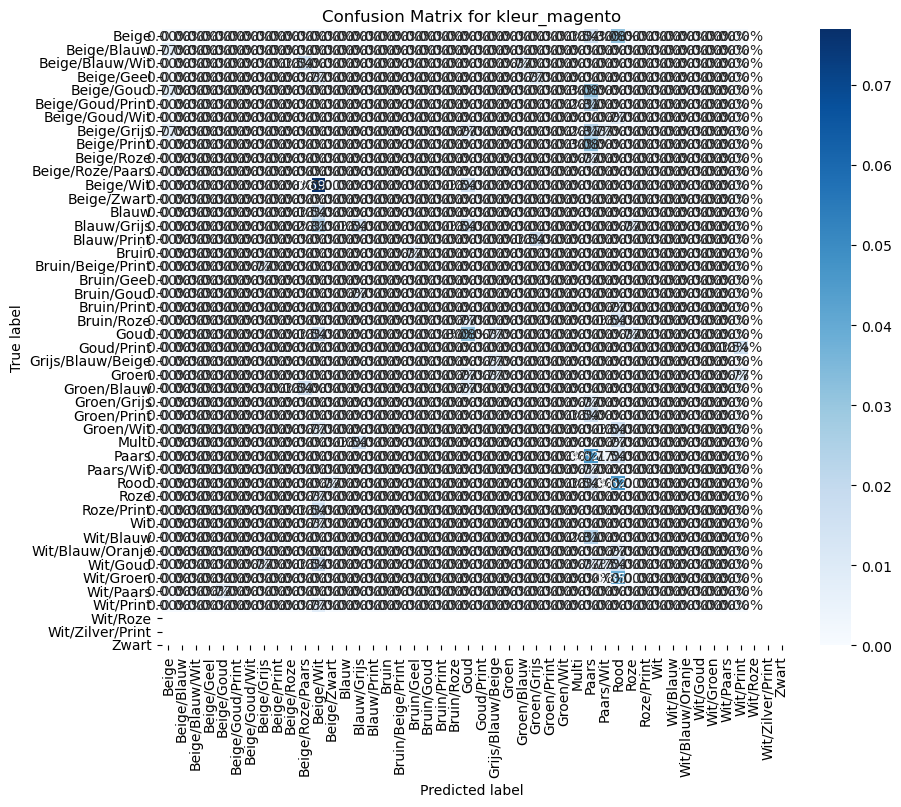

In [ ]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define some parameters
img_width, img_height = 150, 150
base_dir = 'bunnies-jr-ss21-en-ss22_2023-03-31_1035'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
            x = img_to_array(img)  # this is a Numpy array with shape (img_width, img_height, 3)
            images.append(x)
    return images

# Get the itemcodes (shoes) and corresponding kleur_magento from the DataFrame
df = df.dropna(subset=['ItemCode', 'kleur_magento'])  # drop rows with NaN in these columns
itemcode_color_dict = dict(zip(df['ItemCode'], df['kleur_magento']))

# Initialize the images and labels lists
images_list = []
labels_list = []

for itemcode, color in itemcode_color_dict.items():
    item_path = os.path.join(base_dir, itemcode)
    # Check if the itemcode folder exists in the directory
    if os.path.isdir(item_path):
        images = load_images_from_folder(item_path)
        
        # Add each image to the images list and the corresponding color to the labels list
        for image in images:
            images_list.append(image)
            labels_list.append(color)

# Convert to numpy arrays for the model
images_np = np.array(images_list)
labels_np = np.array(labels_list)

# Transform labels to integer for the model
le = LabelEncoder()
labels_np_int = le.fit_transform(labels_np)

# Convert labels to categorical
labels_np_cat = to_categorical(labels_np_int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np_cat, test_size=0.2, random_state=42)

# Normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the model
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the predictions
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Show the accuracy
accuracy = np.sum(y_pred_classes == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy for kleur_magento: {accuracy}')

# Show the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Define class names for labels
class_names = le.classes_

# Plot the confusion matrix with percentage
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx / np.sum(confusion_mtx), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for kleur_magento')
plt.show()


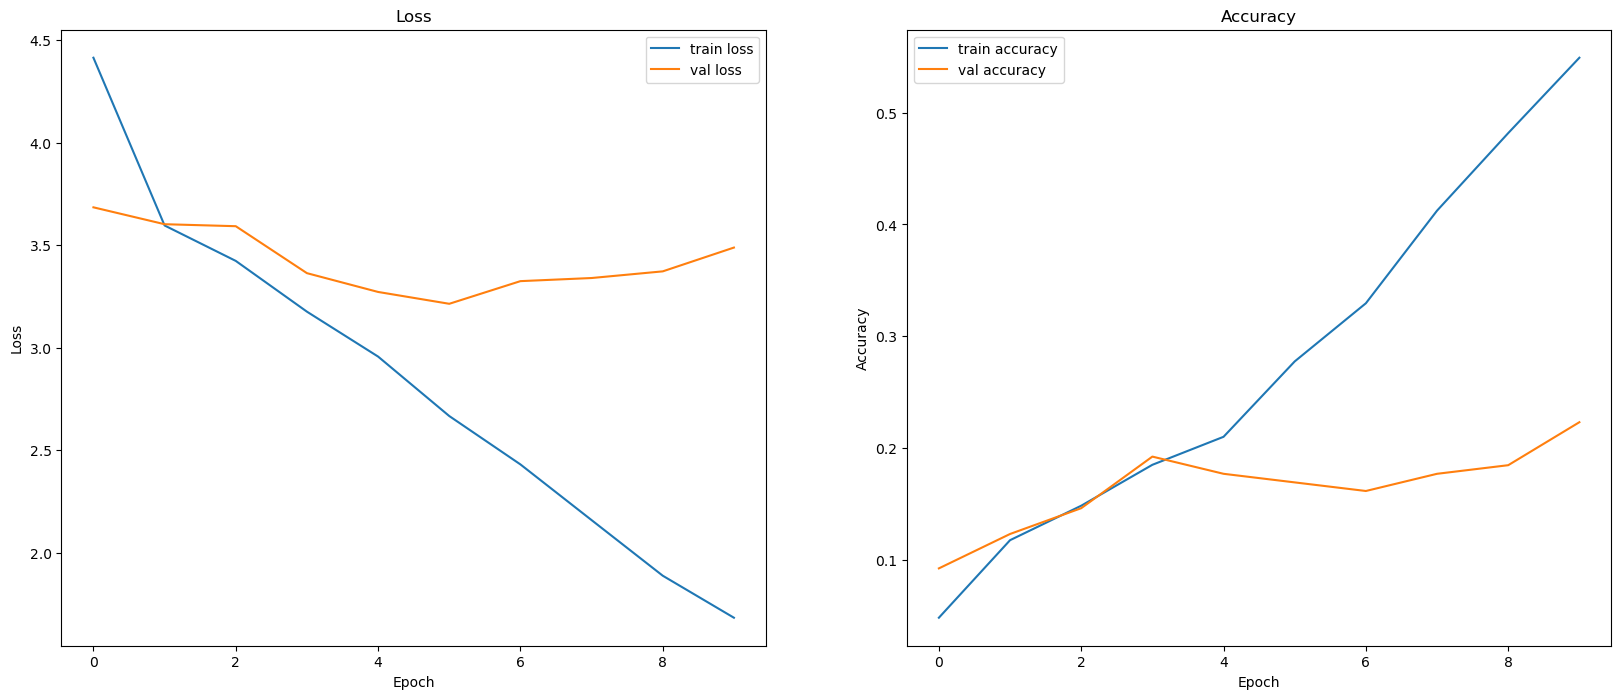

5/5 [==============================] - 0s 29ms/step


In [ ]:
# Plot both loss and accuracy in one figure
plt.figure(figsize=(20,8))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Get the predictions
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


## Material

Epoch 1/10
17/17 [==============================] - 4s 187ms/step - loss: 2.8574 - accuracy: 0.5010 - val_loss: 0.6506 - val_accuracy: 0.6923
Epoch 2/10
17/17 [==============================] - 3s 180ms/step - loss: 0.7017 - accuracy: 0.6243 - val_loss: 0.5655 - val_accuracy: 0.7462
Epoch 3/10
17/17 [==============================] - 3s 181ms/step - loss: 0.4710 - accuracy: 0.8208 - val_loss: 0.4604 - val_accuracy: 0.8308
Epoch 4/10
17/17 [==============================] - 3s 182ms/step - loss: 0.3872 - accuracy: 0.8613 - val_loss: 0.4480 - val_accuracy: 0.8000
Epoch 5/10
17/17 [==============================] - 3s 183ms/step - loss: 0.2884 - accuracy: 0.8902 - val_loss: 0.3396 - val_accuracy: 0.8538
Epoch 6/10
17/17 [==============================] - 3s 184ms/step - loss: 0.2463 - accuracy: 0.9017 - val_loss: 0.3504 - val_accuracy: 0.8615
Epoch 7/10
17/17 [==============================] - 3s 184ms/step - loss: 0.2080 - accuracy: 0.9171 - val_loss: 0.2995 - val_accuracy: 0.8846
Epoch 

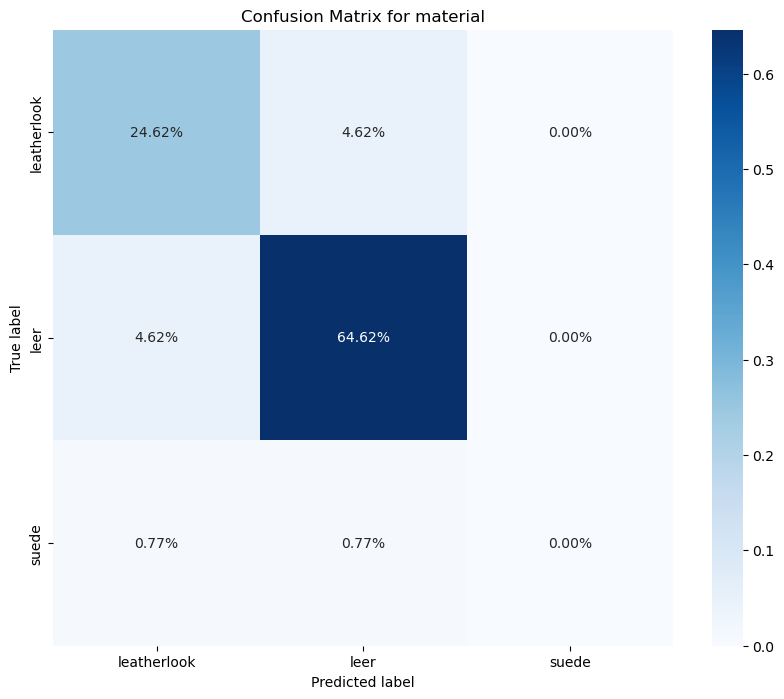

In [ ]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define some parameters
img_width, img_height = 150, 150
base_dir = 'bunnies-jr-ss21-en-ss22_2023-03-31_1035'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
            x = img_to_array(img)  # this is a Numpy array with shape (img_width, img_height, 3)
            images.append(x)
    return images

# Get the itemcodes (shoes) and corresponding material from the DataFrame
df = df.dropna(subset=['ItemCode', 'material'])  # drop rows with NaN in these columns
itemcode_material_dict = dict(zip(df['ItemCode'], df['material']))

# Initialize the images and labels lists
images_list = []
labels_list = []

for itemcode, material in itemcode_material_dict.items():
    item_path = os.path.join(base_dir, itemcode)
    # Check if the itemcode folder exists in the directory
    if os.path.isdir(item_path):
        images = load_images_from_folder(item_path)
        
        # Add each image to the images list and the corresponding material to the labels list
        for image in images:
            images_list.append(image)
            labels_list.append(material)

# Convert to numpy arrays for the model
images_np = np.array(images_list)
labels_np = np.array(labels_list)

# Transform labels to integer for the model
le = LabelEncoder()
labels_np_int = le.fit_transform(labels_np)

# Convert labels to categorical
labels_np_cat = to_categorical(labels_np_int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np_cat, test_size=0.2, random_state=42)

# Normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the model
model4 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the predictions
y_pred = model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Show the accuracy
accuracy = np.sum(y_pred_classes == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy for material: {accuracy}')

# Show the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Define class names for labels
class_names = le.classes_

# Plot the confusion matrix with percentage
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx / np.sum(confusion_mtx), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for material')
plt.show()


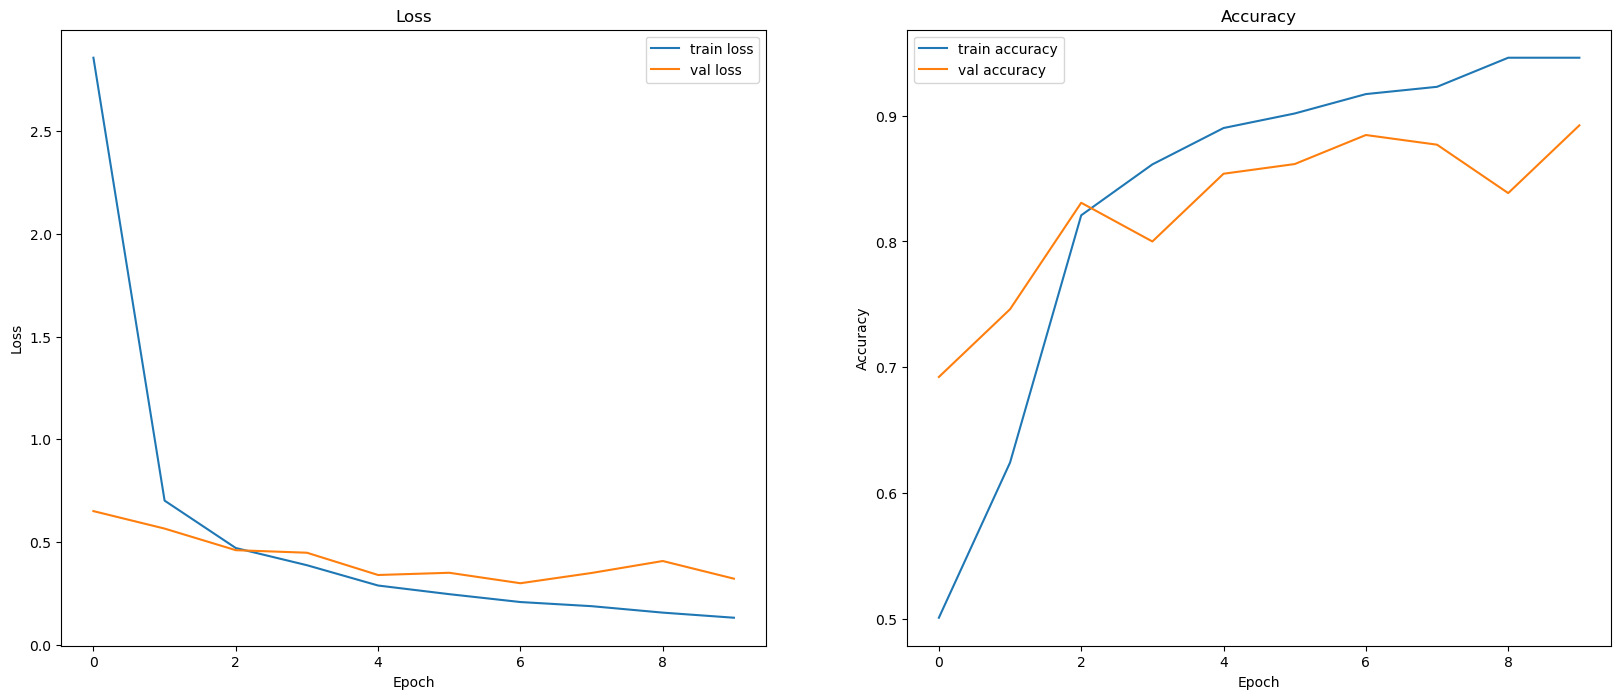

In [ ]:
plt.figure(figsize=(20,8))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

 leatherlook       0.82      0.84      0.83        38
        leer       0.92      0.93      0.93        90
       suede       0.00      0.00      0.00         2

    accuracy                           0.89       130
   macro avg       0.58      0.59      0.59       130
weighted avg       0.88      0.89      0.89       130



c:\Users\maxwe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maxwe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maxwe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion

From using the selected features we are able to predict these features from the images. The next step would be to deploy these models.